University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela

# Lecture 4: Resampling: permutation testing and bootstrap

Background reading: please see Chapter 4 of the "Course notes" available in Moodle.

## 1. Playing with the example from lecture

Experiment with the below example shown in the lecture video. How large does the difference in the means need to be to yield a statistically significant result? How does this change when the number of samples is changed?

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# 1 (already done)
# load the data from CSV file using pandas
fram = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/fram.txt', sep='\t')
fram
# Set the style to "whitegrid"
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True


In [57]:
# Play around with this 
delta_mean = 0.09
n_samples = 500

In [58]:
import numpy as np
import numpy.random as npr

# Here we generate a simulated dataset
# We keep this fixed, except for the difference in means

npr.seed(42)

# Generate two samples
x1 = npr.normal(size=n_samples)
x2 = npr.normal(size=n_samples) + delta_mean

# Concatenate to form a whole
print("mean(x1):", np.mean(x1))
print("mean(x2):", np.mean(x2))
truediff = np.abs(np.mean(x1) - np.mean(x2))

mean(x1): 0.006837994588647575
mean(x2): 0.12182611705600342


In [59]:
npr.seed(42)

# Set the number of permutations
N_perm = 1000

def shuffle(x1, x2):
    """Return a random reshuffling of elements in two arrays."""
    n1 = len(x1)
    z = npr.permutation(np.concatenate((x1, x2)))
    return z[0:n1], z[n1:]

# Repeatedly randomly permute to mix the groups
meandiffs = np.zeros(N_perm)
for i in range(N_perm):
    z1, z2 = shuffle(x1, x2)
    meandiffs[i] = np.abs(np.mean(z1) - np.mean(z2))
print('p-value:', (np.sum(meandiffs >= truediff)+1)/(len(meandiffs)+1))

p-value: 0.053946053946053944


## 2. Working with real data in Python

Statistics is all about data. In Python, the Pandas package provides many tools for working with real data, but its interface can be a little cumbersome. This exercise will familiarise you with the most important features.

The basic data structure in Pandas is DataFrame, which is modelled after data.frame in R. In this course, the DataFrame will be provided by the `pandas.read_csv()` function which reads from a `.csv` file (a text file representing a table, where each line is a row of separated numerical values, where the separator is typically a comma `,` or a tab `\t`).

For our purposes, the most important features of the DataFrame are: 
- the ability to extract selected columns by name using `['colname']` style indexing;
- the ability to extract rows using `.iloc[rows]` style indexing, where `rows` can be integers (list, array, slice) or a boolean array; and 
- the ability to extract the data as a NumPy Array using the `.values` attribute (*Note*: `df.values`, no need to add parentheses as per a function call.).

In order to select subgroups of the data, one can create a boolean index vector and use it for indexing using e.g.
```{python}
Ismokers = (fram['CIG'] > 0).values    # boolean numpy array
smokers = fram.iloc[Ismokers]
```

-------------------------------------

1. Load the data set using the data set using the code below and print the dataframe. Note the column names at the top.
2. Plot a histogram of the values of the ages of the data subjects. (*Hint*: extract the age column and use `.values` to turn it to a Numpy Array.)
3. Compute the correlation coefficient (`np.corrcoef`) of the age and systolic blood pressure (SBP) values in the data.
4. Create index vectors for male and female participants. Plot separate histograms of the cholesterol (CHOL) values of the male and female subjects.

<Axes: xlabel='AGE', ylabel='Count'>

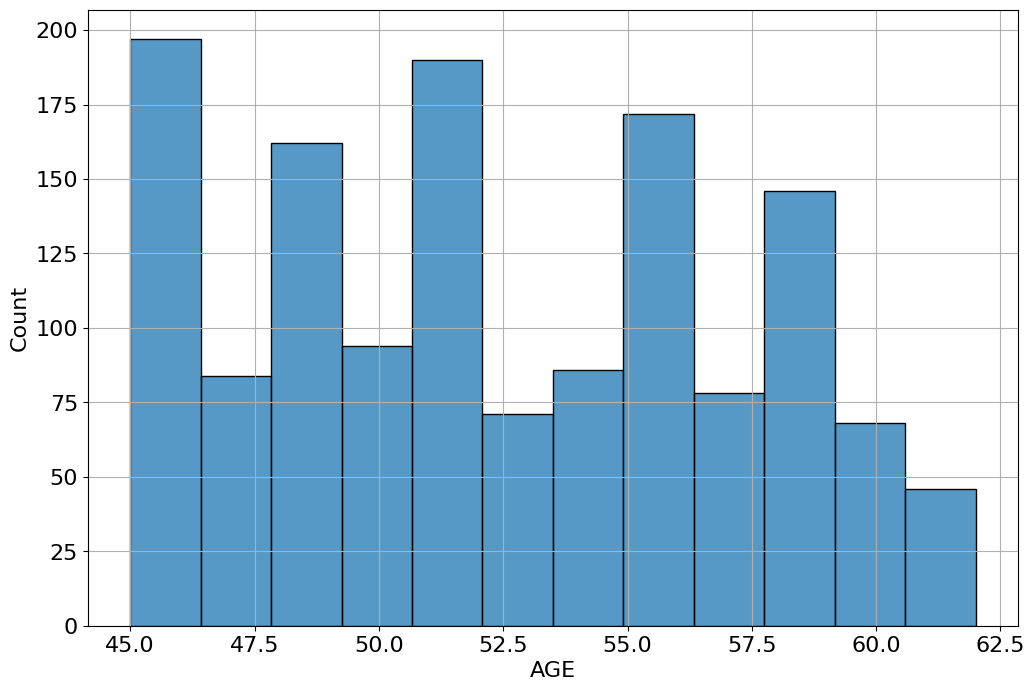

In [60]:
# 2 continue here...
sns.histplot(
    data=fram,
    x="AGE",
)


In [61]:
# 3 correlation between age and blood pressure
fram.loc[:, ['AGE', 'SBP']].corr()
# 4 
males = fram.query('SEX == "male"').index.values
females = fram.query('SEX == "female"').index.values

## 3. Simple permutation testing on real data

1. Implement a permutation test to check if the ages (AGE) of male and female participants in the data set are statistically significantly different using the absolute difference of the means as the test statistic. How do you interpret the result?
2. Try a similar test with other variables in the data set, such as cholesterol level (CHOL). How do you interpret the results?

In [62]:
def permutation_test(x1: np.ndarray, x2: np.ndarray, n_perm: int) -> float:
    permutations = np.zeros(n_perm)
    for i in range(n_perm):
        z1, z2 = shuffle(x1, x2)
        permutations[i] = np.abs(np.mean(z1) - np.mean(z2))
    return (np.sum(permutations >= truediff)+1)/(n_perm+1)

def permutation_test_variable(variable_name: str, n_perm: int = 5000) -> float:
    x1_males = fram.loc[males, variable_name].values
    x2_females = fram.loc[females, variable_name].values
    return permutation_test(x1_males, x2_females, n_perm)

print(f"p-value for SBP: {permutation_test_variable('SBP')}")
print(f"p-value for AGE: {permutation_test_variable('AGE')}")
print(f"p-value for CHOL: {permutation_test_variable('CHOL')}")


p-value for SBP: 0.9428114377124575
p-value for AGE: 0.6506698660267947
p-value for CHOL: 0.9604079184163168


## 4. Bootstrap sampling

See Section 4.3 of the Course notes for background reading.

1. Compute the bootstrap 95% confidence interval for the mean of the variable 'SBP' in the example data set. Compare that with the theoretical interval (see e.g. http://onlinestatbook.com/2/estimation/mean.html ).
2. Compute the bootstrap 95% confidence interval for the median of the variable 'SBP' in the example data set.
3. Compute the bootstrap 95% confidence interval for the correlation between the variables 'SBP' and 'CHOL' in the example data set.

*Hints*: 
- You can use `numpy.random.randint()` to sample the indices for the bootstrap sample and `numpy.percentile()` to extract percentiles from the sampling results.
- Remember that the 95% confidence interval corresponds to the `[2.5, 97.5]` percentiles.

In [63]:
bootstrap_means_sbp = npr.choice(fram['SBP'].values, size=(1000, len(fram['SBP'].values)), replace=True).mean(axis=1)
print(f"SBP mean bootstrap confidence intervals: {np.quantile(bootstrap_means_sbp, [0.025, 0.975])}")
print(f"SBP theoretical confidence intervals: {(np.std(fram['SBP'].values) / np.sqrt(len(fram['SBP'].values)) * np.array([-1.96, 1.96])) + fram['SBP'].mean()}")


SBP mean bootstrap confidence intervals: [146.61902798 149.44225251]
SBP theoretical confidence intervals: [146.61556997 149.55659646]


In [64]:
bootstrap_medians_sbp = np.median(npr.choice(fram['SBP'].values, size=(1000, len(fram['SBP'].values)), replace=True),axis=1)
print(f"SBP median bootstrap confidence intervals: {np.quantile(bootstrap_medians_sbp, [0.025, 0.975])}")

SBP median bootstrap confidence intervals: [140. 144.]


## 5. Using bootstrap to study properties of estimators.

1. Simulate data sets of 1000 samples with zero mean and unit variance from the Gaussian and the Laplace distribution.
2. Estimate the mean, median and standard deviation and their bootstrap confidence intervals. What do you observe?
3. How do the results change when you change the initial data set size?

In [75]:
unit_gaussian = stats.norm(0, 1)
unit_laplace = stats.laplace(0, 1)
x_gaussian = unit_gaussian.rvs(100)
x_laplace = unit_laplace.rvs(100)

In [76]:
bootstrapped_x_gaussian = npr.choice(x_gaussian, size=(1000, len(x_gaussian)), replace=True)
print(f"Gaussian bootstrapped mean CIs {np.quantile(bootstrapped_x_gaussian.mean(axis=1), [0.025, 0.975])}")
print(f"Gaussian bootstrapped median CIs {np.quantile(np.median(bootstrapped_x_gaussian, axis=1), [0.025, 0.975])}")
print(f"Gaussian standard deviation CIs {np.quantile(bootstrapped_x_gaussian.std(axis=1), [0.025, 0.975])}")

Gaussian bootstrapped mean CIs [-0.23441314  0.19121468]
Gaussian bootstrapped median CIs [-0.17925003  0.21820746]
Gaussian standard deviation CIs [0.95265985 1.24722316]


In [77]:
bootstrapped_x_laplace = npr.choice(x_laplace, size=(1000, len(x_laplace)), replace=True)
print(f"Laplace bootstrapped mean CIs {np.quantile(bootstrapped_x_laplace.mean(axis=1), [0.025, 0.975])}")
print(f"Laplace bootstrapped median CIs {np.quantile(np.median(bootstrapped_x_laplace, axis=1), [0.025, 0.975])}")
print(f"Laplace standard deviation CIs {np.quantile(bootstrapped_x_laplace.std(axis=1), [0.025, 0.975])}")

Laplace bootstrapped mean CIs [-0.13425099  0.38492472]
Laplace bootstrapped median CIs [-0.19861472  0.3646786 ]
Laplace standard deviation CIs [1.09583543 1.61574468]


## 6. More complex permutations

Let us focus on the difference in the blood pressure ('DBP') between males and females. A direct test shows that blood pressures of males and females are statistically highly significantly different (very low p-value, i.e. the observed difference would be highly unlikely under the null model). In this exercise we augment the model by balancing the permuted data with respect to another variable: weight ('FRW').

This is a very crude method in this case, because we only look at one arbitrary split in FRW.

1. Run a permutation test on 'DBP' the same way as in Problem 1, i.e. without stratification to low and high weight groups. What is the p-value you obtain? Try to increase the number of permutations until the p-value seems reasonably accurate. (*Note*: this should not take more than a few seconds to run!)
2. Find the four subgroups of the data: males and females with FRW smaller/larger than median. How large are these groups?
3. Construct separate vectors of males and females in high/low FRW groups.
4. Perform a permutation test where males and females are shuffled within both FRW groups but do not mix the FRW groups. Repeat to compute the p-value by checking how often in the permutation you obtain results as extreme as those in the real data. Compare your result with that from case 1.

*Hint*: Look at the example in Sec. 4.2.1 of the Course notes.